<a href="https://colab.research.google.com/github/ManikDeepak/BrainTumorDetection/blob/main/BrainTumorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Detection
We build a classifier to detect the brain tumor (if any) from the MRI scan images. By now it is evident that this is a binary classification problem. Examples of such binary classification problems are Spam or Not spam, Credit card fraud

We will be using the following libraries to help us create the classification model:

*   Python
*   TensorFlow
*   Keras
*   Numpy
*   Scikit-learn
*   Matplotlib
*   OpenCV


# Steps to Develop the Model Using Machine Learning
Our approach to building the classifier is discussed in the steps:

1.  Perform Exploratory Data Analysis (EDA) on brain tumor dataset
2. Build a CNN model
3. Train and Evaluate our model on the dataset





# Step 1: Performing Exploratory Data Analysis


The Dataset im going to use is present on my google drive. So first we are going to mount the google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will first import the libraires required to perform data analysis.

In [ ]:
#importing libraries
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
import cv2

Now we will import the data from the drive and store them in an array.

In [ ]:
path = "/content/drive/MyDrive/brain_tumor_dataset"
image_paths = list(paths.list_images(path))

Since the images are of variable size we going to scale every image to a fixed 225x255 resolution.

In [ ]:
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    images.append(image)
    labels.append(label)

Lets plot the image using matplotlib and see the result.

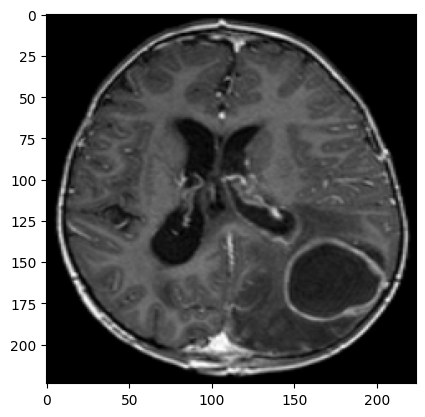

In [ ]:
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])

Importing some libraries for performing data cleaning.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split

We will convert the images into array storing their pixel values so that its easily understandable by the machine. Also the label of the iamges are "Yes" or "No" which are strings which the machinec cant understand so we are going to convert them into so numerical values so that the machine can understand them.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import numpy as np

images = np.array(images) / 255.0
labels = np.array(labels)

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

Now we are going to split the data into 2 parts for testing and training. We are going to keep the ratio of 9 train to 1 test as by playing with the values 9:1 has given the best results.

In [ ]:
(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)

# Building A CNN model
A Convolutional Neural Network or CNN for short is a deep neural network widely used for analyzing visual images. These types of networks work well for tasks like image classification and detection, image segmentation. There are 2 main parts of a CNN:

* A convolutional layer that does the job of feature extraction
* A fully connected layer at the end that utilizes the output of the convolutional layers and predicts the class of the image.

Since the value in the each data is very less. We are going to use tensorflows image generator. The image generator will create new data points based on the values near to it. As dataset size for brain tumor detection is very small to train such deep neural networks, we utilize the power of Transfer Learning to make best predictions. Transfer learning is about leveraging feature representations from a pre-trained model, so you don’t have to train a new model from scratch.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG16

We are going to keras VGG16 state-of-the-art network model. The architecture of the model is given below.

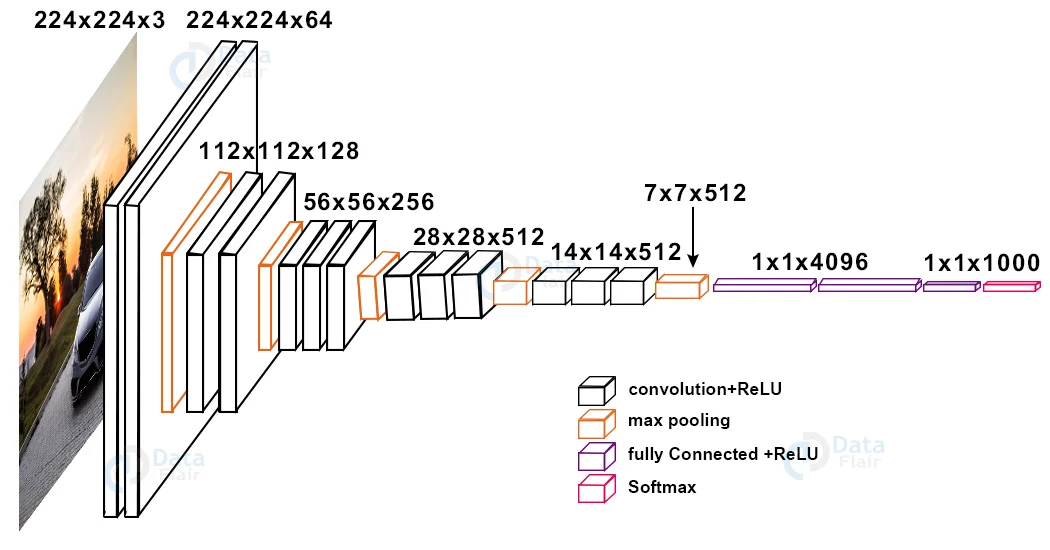

For our project we will just swap the last layer of the VGG16 model with our preferable image. Then freeze the layers of our model. By doing this, the network is not trained from the very beginning. It uses the weights of previous layers and continues training for the layers we added on top of those layers. This reduces the training time by a drastic amount.

In [ ]:
base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input

base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Now build the model and compile it using the Adam as optimizer with a learning rate of 0.001 and accuracy as metric. As we are building a binary classifier and the input is an image, binary cross entropy is used as a loss function.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Train and Evaluate the Model
Now we will define some hypeparameters.
The model is trained on 10 epochs (full iterations) with train_steps for training set and validation_steps for validation set in each epoch. The batch size for each epoch is taken as 8.

In [ ]:
batch_size = 8
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 10

Now train the model.

In [ ]:
history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size), steps_per_epoch= train_steps, validation_data = (test_X, test_Y), validation_steps= validation_steps, epochs= epochs);ac=94.0734

Epoch 1/10


<ipython-input-19-658a9bb046f8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size), steps_per_epoch= train_steps, validation_data = (test_X, test_Y), validation_steps= validation_steps, epochs= epochs);ac=94.0734


28/28 [==============================] - 3s 106ms/step - loss: 0.5027 - accuracy: 0.7808 - val_loss: 0.5178 - val_accuracy: 0.8462
Epoch 2/10
28/28 [==============================] - 3s 109ms/step - loss: 0.4784 - accuracy: 0.8174 - val_loss: 0.4906 - val_accuracy: 0.8077
Epoch 3/10
28/28 [==============================] - 4s 153ms/step - loss: 0.4788 - accuracy: 0.7763 - val_loss: 0.4805 - val_accuracy: 0.7692
Epoch 4/10
28/28 [==============================] - 3s 114ms/step - loss: 0.4432 - accuracy: 0.8174 - val_loss: 0.5557 - val_accuracy: 0.7308
Epoch 5/10
28/28 [==============================] - 3s 107ms/step - loss: 0.4596 - accuracy: 0.7763 - val_loss: 0.4681 - val_accuracy: 0.8077
Epoch 6/10
28/28 [==============================] - 3s 114ms/step - loss: 0.4286 - accuracy: 0.8125 - val_loss: 0.4603 - val_accuracy: 0.7692
Epoch 7/10
28/28 [==============================] - 4s 122ms/step - loss: 0.4465 - accuracy: 0.7854 - val_loss: 0.4660 - val_accuracy: 0.8077
Epoch 8/10
28/28 

The accuracy of the model is varying everytime we run the code but it is in the range of 86 to 93% accuracy range.Now let’s evaluate our model using the predict() function.

The predictions made by the model will be an array with each value being the probability that it predicts the image belongs to that category. So, we take the maximum of all such probabilities and assign the predicted label to that image input.

A confusion matrix is a matrix representation showing how well the trained model predicts each target class with respect to the counts. It contains 4 values in the following format:

TP FN

FP FN

* True positive (TP): Target is positive and the model predicted it as positive
* False negative (FN): Target is positive and the model predicted it as negative
* False positive (FP): Target is negative and the model predicted it as positive
* True negative (TN): Target is negative and the model predicted it as negative.

The classification report provides a summary of the metrics precision, recall and F1-score for each class/label in the dataset. It also provides the accuracy and how many dataset samples of each label it categorized.

Now, let’s find the overall accuracy of the model using the formula:

 (TP + TN) / (TP + FN + FN + TN)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)

4/4 [==============================] - 0s 69ms/step
              precision    recall  f1-score   support

          no       0.69      0.90      0.78        10
         yes       0.92      0.75      0.83        16

    accuracy                           0.81        26
   macro avg       0.81      0.82      0.81        26
weighted avg       0.83      0.81      0.81        26

[[ 9  1]
 [ 4 12]]


Accuracy: 80.7692%


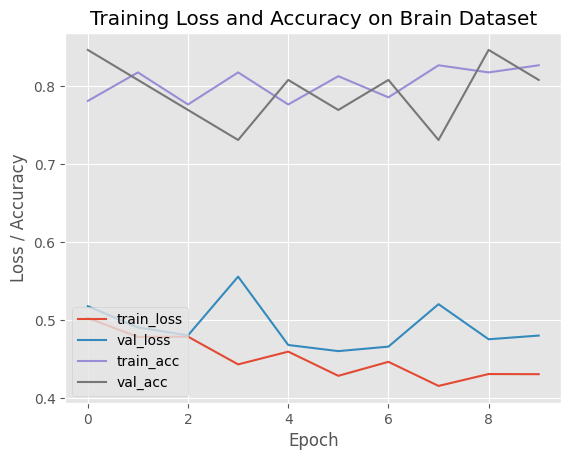

In [ ]:
total = sum(sum(cm))
accuracy = ((cm[0, 0] + cm[1, 1]) / total)*100
print("Accuracy: {:.4f}%".format(accuracy))
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")

# Conclusion
In brain tumor classification using machine learning, we built a binary classifier to detect brain tumors from MRI scan images. We built our classifier using transfer learning and obtained an accuracy of 88.4% and visualized our model’s overall performance.